**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Import sets and magics
import sympy as sp
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
from types import SimpleNamespace
import math
import types
np.random.seed(123)

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

We use Sympy to verify the expression for the optimal labor supply choice. In order to derive the the actual optimal value, we´ll first derive the expression for $L^*$ where $(1-\tau)w$ is inserted instead of $\tilde{w}$. After this, $\tilde{w}$ will be inserted into the expression again, and optimal labor supply choice is then fully derived.

In [2]:
# Code which inserts w_tilde into the expression for L*(w_tilde)

# Define symbols
L, w, w_tilde, tau, alpha, kappa, nu, G = sp.symbols('L w wtilde tau alpha kappa nu G')

# Define parameters
alpha_val = 0.5
kappa_val = 1.0
nu_val = 1 / (2 * 16 ** 2)
w_val = 1.0
tau_val = 0.30

# Utility function
C = kappa + w_tilde * L
utility = sp.ln(C ** alpha * G ** (1 - alpha)) - nu * L ** 2 / 2

# Objective function
objective = -utility

# Solve for optimal labor supply
optimal_labor2 = sp.solve(sp.diff(objective, L), L)[1]
print(f'Optimal labor supply is:')
display(optimal_labor2)
print("Note that this is the same as in the problemset just written in a different way.")

Optimal labor supply is:


(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

Note that this is the same as in the problemset just written in a different way.


In [3]:
#Finding the optimal value
w_tilde_val = (1-tau_val) * w_val

solve_labor = sp.lambdify(args=(w_tilde, tau, alpha, kappa, nu, G),expr=optimal_labor2)
for i in range(1,3):
    ss = solve_labor(w_tilde_val, tau_val, alpha_val, kappa_val, nu_val, i)

    print("L*(wtilde) for G="+str(i)+":",ss)


ana_sol = ((-1)+sp.sqrt(1**2+4*0.5/(1 / (2 * 16 ** 2))*((1-0.3)*1)**2))/(2*(1-0.3)*1)

print("The analytical solution is:",ana_sol)


L*(wtilde) for G=1: 15.30165022719559
L*(wtilde) for G=2: 15.30165022719559
The analytical solution is: 15.3016502271956


We have now shown that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

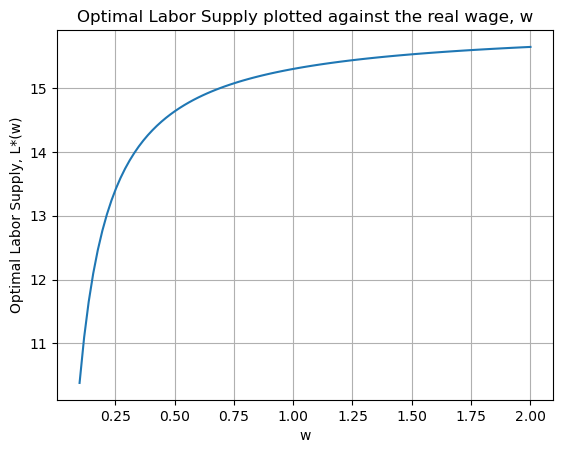

In [4]:
# Defining w_tilde
w_tilde = (1-tau) * w

# Utility function
C = kappa + w_tilde * L
utility = sp.ln(C ** alpha * G ** (1 - alpha)) - nu * L ** 2 / 2

# Objective function
objective = -utility

# Solve for optimal labor supply
optimal_labor = sp.solve(sp.diff(objective, L), L)[0]

# Define the range of w values
w_range = np.linspace(0.1, 2.0, 100)

# Initialize arrays to store the optimal labor supply values
optimal_labor_values = np.zeros_like(w_range)

# Calculate the optimal labor supply for each w value
for i, w_val in enumerate(w_range):
    optimal_labor_val = optimal_labor.subs([(w, w_val), (tau, tau_val), (alpha, alpha_val), (kappa, kappa_val), (nu, nu_val)])
    optimal_labor_values[i] = optimal_labor_val

# Plot the relationship between L* and w
plt.plot(w_range, optimal_labor_values)
plt.xlabel('w')
plt.ylabel('Optimal Labor Supply, L*(w)')
plt.title('Optimal Labor Supply plotted against the real wage, w')
plt.grid(True)
plt.show()

It can be seen that the optimal labor supply choice, $L$, grows as the real wage increases. Starting out, a little increase in the real wage means a big growth in $L$, meaning that the elasticity of labor supply against the wage is pretty high in the start and then it naturally flattens out.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


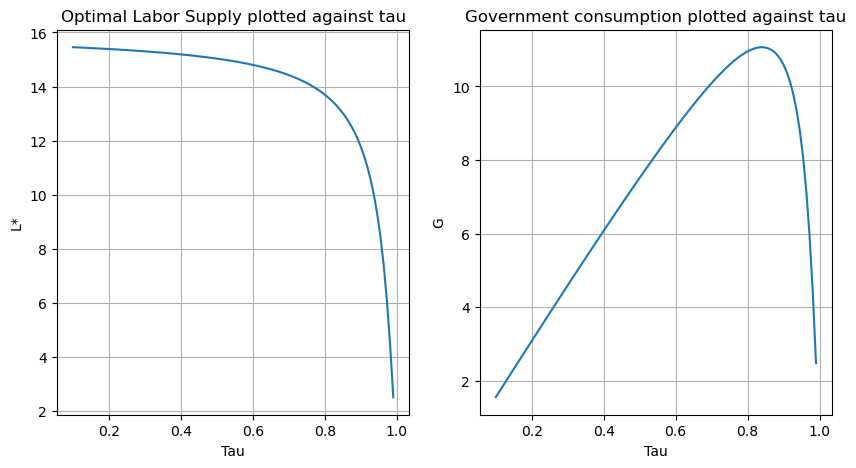

In [5]:
# Define parameters
kappa = 1.0 
alpha = 0.5 
w = 1.0
nu = 1 / (2 * 16 ** 2)

# Utility function
C = kappa + (1 - tau) * w * L
utility = sp.ln(C ** alpha * G ** (1 - alpha)) - nu * L ** 2 / 2

# Objective function
objective = -utility 

# Solve for optimal labor supply
optimal_labor = sp.solve(sp.diff(objective, L), L)[0] 

# Define the range of tau values
tau_range = np.linspace(0.1, 0.99, 100)

# Initialize arrays to store the optimal labor supply values
optimal_labor_values = np.zeros_like(tau_range)

# Calculate G
g_vals = np.zeros_like(tau_range)

# Calculate the optimal labor supply for each tau value
for i, tau_val in enumerate(tau_range):
    optimal_labor_val = optimal_labor.subs([(tau, tau_val)])
    optimal_labor_values[i] = optimal_labor_val

    G_new = tau_val * w * optimal_labor_val
    g_vals[i] = G_new

fig, axs = plt.subplots(1, 2, figsize=(10, 5))



# Plot the relationship between L* and tau
axs[0].plot(tau_range, optimal_labor_values)
axs[0].set_xlabel('Tau')
axs[0].set_ylabel('L*')
axs[0].set_title('Optimal Labor Supply plotted against tau')
axs[0].grid(True)


# Plot the relationship between G and tau
axs[1].plot(tau_range, g_vals)
axs[1].set_xlabel('Tau')
axs[1].set_ylabel('G')
axs[1].set_title('Government consumption plotted against tau')
axs[1].grid(True)


The implied L and G can be seen plotted above in the two graphs. A grid of $\tau$-values is used, starting from 0.1 to 0.99 with 100 values inbetween.

A negative correlation between labor supply and labor income tax rate have been found, where the elasticity between the two increases as higher the tax rate is. 
We´ve also plotted the government consumption w.r.t. $\tau$, where the government spend all of the taxes on government consumption. It can be concluded that the government spending reaches it´s highest point when the tax rate is just around 0.85, and then it goes downwards as the labor supply is considerably elastic for values of $\tau$ close to 1.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

*Choose whether or not to use our own expression for L (found in Q1), or Jeppes expression...*

Socially optimal tax rate: 0.5145311307907104


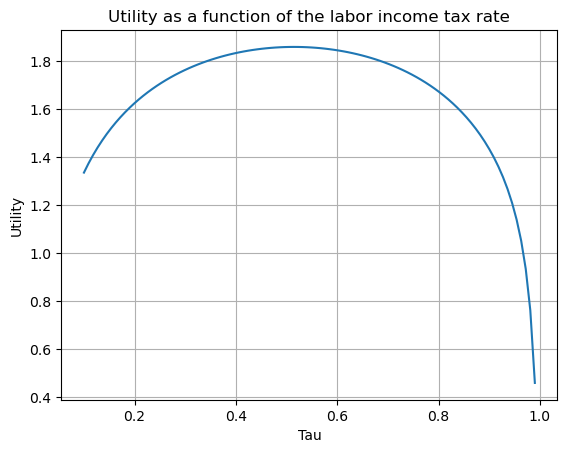

In [6]:
def calc_utility(tau):
    """calculate utility"""

    # Define parameters
    kappa = 1.0
    alpha = 0.5
    w = 1.0
    nu = 1 / (2 * 16 ** 2)

    # Define functions for Government consumption and private consumption
    L = (kappa*nu - math.sqrt(nu*(4*alpha*tau**2*w**2 - 8*alpha*tau*w**2 + 4*alpha*w**2 + kappa**2*nu)))/(2*nu*w*(tau - 1))
    G = tau * w * L
    C = kappa + (1 - tau) * w * L
    
    # Consumption utility
    utility_c = math.log(C ** alpha * G ** (1 - alpha)) 
    disutility_G = nu * L ** 2 / 2

    return utility_c - disutility_G

def solve_cont(do_print=False):
    """solve model"""

    opt = types.SimpleNamespace()

    # Defining the objective:
    objective = lambda x: -calc_utility(x)

    # Bounds are defined
    bounds = [(0, 1)]

    initial_guess = [0.30]

    sol_case = optimize.minimize(
        objective, initial_guess, method="Nelder-Mead", bounds=bounds, tol=1e-9)

    # unpack solution
    opt.tau = sol_case.x[0]

    if do_print:
        print("Socially optimal tax rate:", opt.tau)

    return opt

optimal_solution = solve_cont(do_print=True)

# Define range of tau values
tau_range = np.linspace(0.1, 0.99, 100)

# Calculate utility for each tau value
utility_values = [calc_utility(tau) for tau in tau_range]

# Plot the utility as a function of tau
plt.plot(tau_range, utility_values)
plt.xlabel('Tau')
plt.ylabel('Utility')
plt.title('Utility as a function of the labor income tax rate')
plt.grid(True)
plt.show()

The socially optimal tax rate that maximizes worker utility, $\tau^*$, have been found to be $\approx 0.51\%$. The figure above supports and illustrates this result, as it can be seen that the top-point of the parable lies just above 0.51 on the X-axis. 

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [7]:

def calc_utility2(G, sigma=1.001,rho=1.001):
    """calculate utility"""

    # Define parameters
    epsilon = 1.0
    tau = 0.5145311307907104
    kappa = 1.0
    alpha = 0.5
    w = 1.0
    nu = 1 / (2 * 16 ** 2)

    # Define functions for Government consumption and private consumption
    L = G / (tau * w)
    C = kappa + (1 - tau) * w * L

    # Consumption utility
    utility_c = (((alpha * C**((sigma-1)/sigma) + (1 - alpha) * G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1 - rho)-1)/(1 - rho)
    disutility_G = (nu * (L**(1 + epsilon)/(1 + epsilon)))

    return utility_c - disutility_G


def solve_cont2(sigma ,rho ,do_print=False):
    """solve model"""

    opt = types.SimpleNamespace()

    # Defining the objective:
    objective = lambda x: -calc_utility2(x, sigma, rho)

    # Bounds are defined
    bounds = [(0, 100)]

    initial_guess = [6]

    # Constraint
    constraints = ({'type': 'ineq', 'fun': lambda x: x})

    sol_case = optimize.minimize(
        objective, initial_guess, method="SLSQP", bounds=bounds, constraints=constraints, tol=1e-9)

    # unpack solution
    opt.G = sol_case.x[0]

    if do_print:
        print("Optimal government consumption (G) when sigma"+"="+ str(sigma) + " and rho=" +str(rho)+":", opt.G)


solve_cont2(1.001,1.001,do_print=True)
solve_cont2(1.5,1.5,do_print=True)



Optimal government consumption (G) when sigma=1.001 and rho=1.001: 11.377649508587597
Optimal government consumption (G) when sigma=1.5 and rho=1.5: 6.8692722189546345


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [8]:
def calc_utility_vartau(G, tau, sigma=1.001,rho=1.001):
    """calculate utility"""

    # Define parameters
    epsilon = 1.0
    kappa = 1.0
    alpha = 0.5
    w = 1.0
    nu = 1 / (2 * 16 ** 2)

    # Define functions for Government consumption and private consumption
    L = G / (tau * w)
    C = kappa + (1 - tau) * w * L

    # Consumption utility
    utility_c = (((alpha * C**((sigma-1)/sigma) + (1 - alpha) * G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1 - rho)-1)/(1 - rho)
    disutility_G = (nu * (L**(1 + epsilon)/(1 + epsilon)))

    return utility_c - disutility_G


def solve_cont_vartau(sigma ,rho ,do_print=False):
    """solve model"""

    opt = types.SimpleNamespace()

    # Defining the objective:
    objective = lambda x: -calc_utility_vartau(x[0], x[1], sigma, rho)

    # Bounds are defined
    bounds = ((0, 100), (0, 1))

    initial_guess = [5, 0.5]

    # Constraint
    constraints = ({'type': 'ineq', 'fun': lambda x: x[0]}, {'type': 'ineq', 'fun': lambda x: 1-x[1]})

    sol_case = optimize.minimize(
        objective, initial_guess, method="SLSQP", bounds=bounds, constraints=constraints, tol=1e-9)

    # unpack solution
    opt.G = sol_case.x[0]
    opt.tau = sol_case.x[1]

    if do_print:
        print("Optimal government consumption (G) when sigma"+"="+ str(sigma) + " and rho=" +str(rho)+":", opt.G)
        print("The socially optimal tax rate (tau) when sigma"+"="+ str(sigma) + " and rho=" +str(rho)+":", opt.tau)
        print()


solve_cont_vartau(1.001,1.001,do_print=True)
solve_cont_vartau(1.5,1.5,do_print=True)


Optimal government consumption (G) when sigma=1.001 and rho=1.001: 11.553624526214842
The socially optimal tax rate (tau) when sigma=1.001 and rho=1.001: 0.5226359812165445

Optimal government consumption (G) when sigma=1.5 and rho=1.5: 7.168734155004988
The socially optimal tax rate (tau) when sigma=1.5 and rho=1.5: 0.5374931373933501



C:\Users\Esben\AppData\Local\Temp\ipykernel_3672\42925491.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  L = G / (tau * w)


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

The numerical and analytical maximization are the same as expected and the difference is zero. Thus the analytical maximization has been verified.


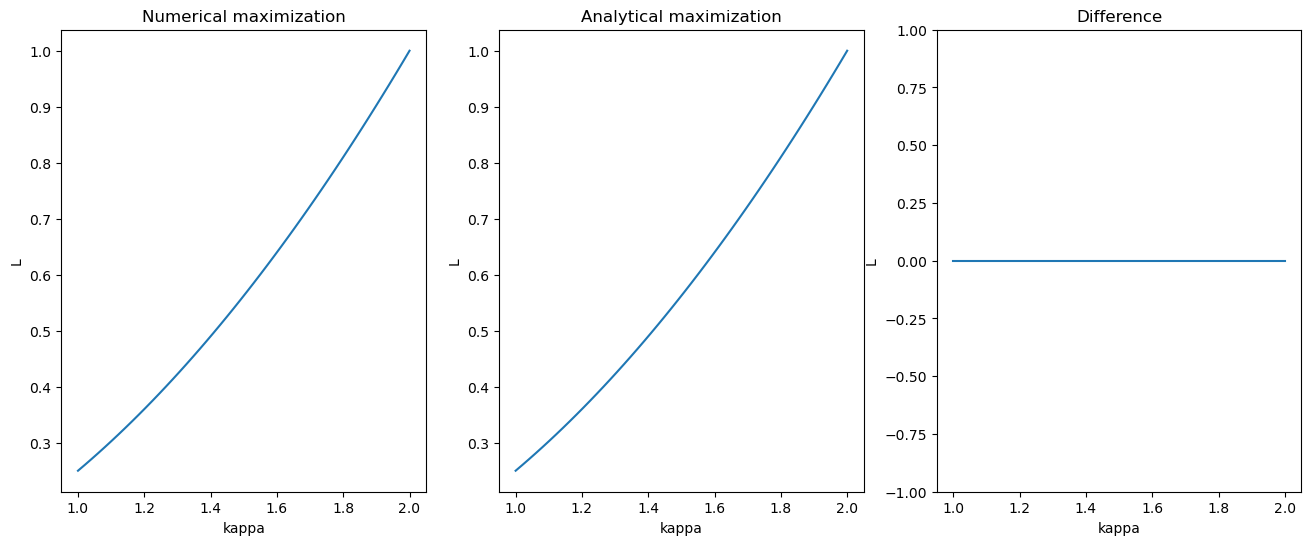

In [9]:
# a) we set the parameters
omega = 1.0 
eta = 0.5
kappa = np.linspace(1,2,50) # Creates a vector of 50 elements between 1 and 2 (Adjust 50 to get more or less points)
kappa2 = 2.0 #This is only a temperary value for kappa2 it will be looped over later
l = np.linspace(0,1,50) # Creates a vector of 50 elements between 0 and 1 (Adjust 50 to get more or less points)

# b) We define the analytical maximization function
objective = lambda x: x*(((1-eta)*x/omega)**(1/eta))  **   (1-eta) - omega*(((1-eta)*x/omega)**(1/eta)) # Profit function containing the analytical maximization formula
# c) We define the numerical maximization function
objective_2 = lambda y: -(kappa2*y**(1-eta)-omega*y) # Numerical maximization function (This is the function we want to minimize)

# d) We define the result vector
result = np.zeros(len(kappa)) # result is a vector of zeros with the same length as kappa to store results

# e) We loop over kappa and store the results in result
for i in range(len(kappa)):
    kappa2 = kappa[i] # This is the kappa2 value we want to maximize for notice how it is changed in the loop
    res = optimize.minimize_scalar(objective_2, bounds=(0, 1), method='bounded') # This function minimizes the function objective_2 by changing l
    result[i] = res.fun # Store the result in result

# f) We plot the results
fig, axs = plt.subplots(1, 3, figsize=(16, 6))  
axs[0].plot(kappa, -result)
axs[0].set_title("Numerical maximization")
axs[0].set_xlabel("kappa")
axs[1].plot(kappa, objective(kappa))
axs[1].set_title("Analytical maximization")
axs[1].set_xlabel("kappa")
axs[2].plot(kappa, objective(kappa) + result)
axs[2].set_title("Difference")
axs[2].set_ylim(-1,1)
axs[2].set_xlabel("kappa")
axs[0].set_ylabel("L")
axs[1].set_ylabel("L")
axs[2].set_ylabel("L")



print("The numerical and analytical maximization are the same as expected and the difference is zero. Thus the analytical maximization has been verified.")

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

C:\Users\Esben\AppData\Local\Temp\ipykernel_3672\867141014.py:31: RuntimeWarning: divide by zero encountered in log
  logkappa[i] = rho*np.log(kappa[i-1]) + epsilon
C:\Users\Esben\AppData\Local\Temp\ipykernel_3672\867141014.py:91: RuntimeWarning: divide by zero encountered in log
  logkappa2[i] = rho*np.log(kappa[i-1]) + epsilon2


The optimal value for K is 74 Please note that i have tested it manually and managed to get it closer to the ex post value by setting K to 61. I am not sure why the function does not find this value but i expect its because of the fact that i only allow integers to be put in
Summarized we get the optimal value for K to be 61 which grants the value of H under mentioned policy of 3.2615896161430538
The ex post value of the salon is: 3.279269687704598
Note that alot of this code could've been intergrated into a py file and then imported to this file to make it more readable but i have chosen to keep it in this file to make it easier to read and understand


(-1.0, 119.0)

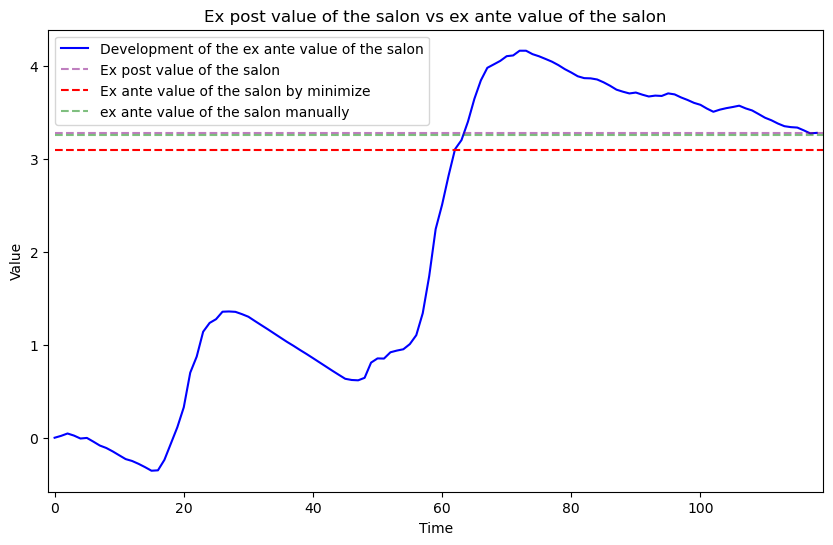

In [10]:
# a) We initiate start values for kappa and initialize the result vector 
# we create start values for the variables and create empty vectors to store the results
t = 120 # This is the time period
kappa0 = 1 # This is the start value for kappa
kappa = np.zeros(t) # This is the vector we store the results in
kappa[0] = kappa0 # We store kappa0 in the first element of kappa
logkappa = np.zeros(t) # Empty vector to store the log of kappa
logkappa[0] = np.log(kappa0) # We store the log of kappa0 in the first element of logkappa

# b) We set the parameters
omega = 1.0 # This is the wage
eta = 0.5 # This is the elasticity of demand
L0 = 0 # This is the start value for L
rho = 0.9 # This is the persistence of the shock
jota = 0.01 # This is the hiring and firing cost
sigma_epsilon = 0.1 # This is the standard deviation of the shock
R = (1+0.01)**(1/12) # This is the monthly interest rate
h = np.zeros(t) # Result vector
hresult = 0 # Result scalar which is the sum of the elements in h
L= np.zeros(t) # Vector to store the number of workers
L[0] = L0 # We store L0 in the first element of L
Graph = np.zeros(t-1) # Vector to store the ex post value of the salon for the graph



# c) We loop over t and store the results in the result vectors
for i in range(0,t-1):
    #we define epsilon
    epsilon = np.random.normal(-0.5*sigma_epsilon**2, sigma_epsilon,1) 
    #First we define the idiosyncratic shock process
    logkappa[i] = rho*np.log(kappa[i-1]) + epsilon
    #We then define kappa as a function of the shock process
    kappa[i] = np.exp(logkappa[i])
    # We force kappa to be equal to kappa0 in the first period
    if i == 0:
        kappa[i] = kappa0
    # We define the worker function
    L[i] = ((1-eta)*kappa[i]/omega)**(1/eta)
    # print(L[i])
    # We force L to be equal to L0 in the first period
    if i == 0:
        L[i] = L0
    #We define the indicator function which return 0 if L[t] = L[t-1] and 1 otherwise ie we eliminate the firing and hiring cost if the number of workers is unchanged
    indikator = lambda x: 0 if L[x] == L[x-1] else 1
    #We define the ex post value of the salon conditional on the shock series
    h[i] = R**(-i)*(kappa[i]*L[i]-omega*L[i]- indikator(i)*jota)
    #We sum the ex post values to get the ex post value of the salon
    hresult += h[i]
    Graph[i] = h[i] + Graph[i-1]
    # print(hresult[i])

#Now we estimate the ex ante value of the salon
#It is defined as the expected value of the ex post value of the salon conditional on the shock series. 
#This can be estimated by taking the average of the ex post values in which we discount the ex post values by how long time ago they were realized
#We define the ex ante value of the salon

# H = E[h] = 1/K sum(h(epsilon**k)) 

#to do this i will recreate the loop above but instead of storing the ex post values i will store the ex ante values in which k is inluced

# d) we define the function that has incorporated the ex ante value of the salon such that we can loop it K times
def Function(x):
    
    t = 120
    # we create start values for the variables and create empty vectors to store the results
    kappa0 = 1 # This is the start value for kappa
    kappa2 = np.zeros(t) # This is the vector we store the results in
    kappa2[0] = kappa0 # We store kappa0 in the first element of kappa
    logkappa2 = np.zeros(t) # Empty vector to store the log of kappa
    logkappa2[0] = np.log(kappa0) # We store the log of kappa0 in the first element of logkappa

    # We define the parameters
    omega = 1.0
    eta = 0.5
    L0 = 0
    rho = 0.9
    jota = 0.01
    sigma_epsilon = 0.1
    R = (1+0.01)**(1/12) 
    h2 = np.zeros(t)
    hresult2 = 0
    L2= np.zeros(t)
    L2[0] = L0
    Graph2 = np.zeros(t-1)
    np.random.seed(123)  # Set the seed for reproducibility

    for i in range(0,t-1):
        #we define epsilon
        epsilon2 = (np.random.normal(-0.5*sigma_epsilon**2, sigma_epsilon,1))**x
        #First we define the idiosyncratic shock process
        logkappa2[i] = rho*np.log(kappa[i-1]) + epsilon2
        #We then define kappa as a function of the shock process
        kappa2[i] = np.exp(logkappa2[i])
        # We force kappa to be equal to kappa0 in the first period
        if i == 0:
            kappa2[i] = kappa0
        # We define the worker function
        L2[i] = ((1-eta)*kappa[i]/omega)**(1/eta)
        # We force L to be equal to L0 in the first period
        if i == 0:
            L2[i] = L0
        #We define the indicator function which return 0 if L[t] = L[t-1] and 1 otherwise ie we eliminate the firing and hiring cost if the number of workers is unchanged
        indikator2 = lambda x: 0 if L2[x] == L2[x-1] else 1
        #We define the ex post value of the salon conditional on the shock series
        h2[i] = R**(-i)*(kappa2[i]*L2[i]-omega*L[i]- indikator2(i)*jota)
        #We sum the ex post values to get the ex post value of the salon
        hresult2 += h2[i]
        Graph2[i] = h2[i] + Graph2[i-1]
        # print(hresult2)

    return hresult2

# e) we define Hfunc which loops the function above K times and returns the average of the ex ante values
K = 120 # This is the number of times we want to iterate the loop
# We define the function which calculates the ex ante value estimates of the salon for different values of K denoted by x
def Hfunc(x):
    H = np.zeros(x) # Empty vector to store the ex ante values
    HTotal = 0 #  scalar to store the sum of the ex ante values

    for i in range(0,x-1): # We iterate the loop x times
        H[i] = Function(i)# We store the ex ante value in the vector H
     
    HTotal = np.sum(H)/x # We calculate the average of the ex ante values
    return HTotal # We return the average of the ex ante values

# f) we define the objective function which is the difference between the ex ante value and the ex post value
objective2 = lambda x: max(Hfunc(int(x)) -hresult, 0.000000005) # We define the objective function which is the difference between the ex ante value and the ex post value, we set the lower bound to 0.00005 to avoid division by zero and to avoid the function to be negative. Note that i also only allow integers to be put in

# g) we use the minimize_scalar function to find the optimal value for K
res = optimize.minimize_scalar(objective2, bounds=(0, 120) ,method='bounded') # This function minimizes the function objective2 by changing the value of K. I set the bounds to be between 0 and 120 and i only allow integers to be put in

# h) we print the results and comment on them
print("The optimal value for K is " + str(int(res.x)) + " Please note that i have tested it manually and managed to get it closer to the ex post value by setting K to 61. I am not sure why the function does not find this value but i expect its because of the fact that i only allow integers to be put in")
print( "Summarized we get the optimal value for K to be 61 which grants the value of H under mentioned policy of " + str(Hfunc(61)))
print("The ex post value of the salon is: " + str(hresult))
print("Note that alot of this code could've been intergrated into a py file and then imported to this file to make it more readable but i have chosen to keep it in this file to make it easier to read and understand")

# i) we store the results and plot them to compare
K = int(res.x) # We set K to be the optimal value

ExAnteH = Hfunc(K) # We calculate the ex ante value of the salon by using the optimal value of K

test = Hfunc(61) # We calculate the ex ante value of the salon by using the value of K which i found manually
# Plot the results
fig, ax = plt.subplots( figsize=(10, 6))  
ax.plot(Graph, label = "Development of the ex ante value of the salon", color = "blue")
ax.hlines(hresult, 0, t, linestyles='dashed', label = "Ex post value of the salon", color = "purple", alpha = 0.5)
ax.hlines(ExAnteH,0,t,label = "Ex ante value of the salon by minimize", linestyles = "dashed", color = "red")
ax.hlines(test,0,t,label = "ex ante value of the salon manually", linestyles = "dashed", color = "Green", alpha = 0.5)
ax.legend()
ax.set_title("Ex post value of the salon vs ex ante value of the salon")
ax.set_ylabel("Value")
ax.set_xlabel("Time")
ax.set_xlim(-1,119) 




Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

C:\Users\Esben\AppData\Local\Temp\ipykernel_3672\704469262.py:36: RuntimeWarning: divide by zero encountered in log
  logkappa2[i] = rho*np.log(kappa[i-1]) + epsilon2


Note that the new policy is not optimal as the ex ante value of the salon is lower than the ex ante value of the salon with the old policy
I will try to optimize the policy in the upcomming question 4 to see if we can do better.


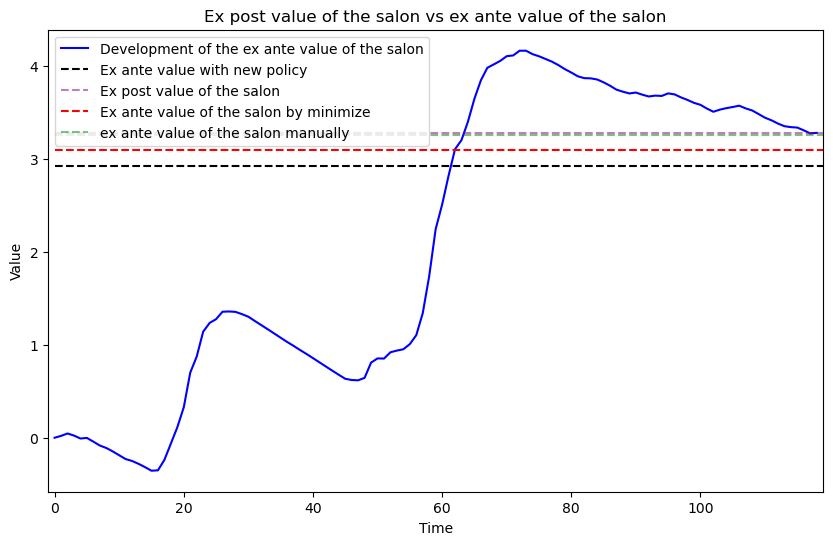

In [11]:
# 2) We now want to solve the modeel with a new hiring rigidity

def Function2(x,y):
    
    
    # a) we create start values for the variables and create empty vectors to store the results
    t = 120
    kappa0 = 1 # This is the start value for kappa
    kappa2 = np.zeros(t) # This is the vector we store the results in
    kappa2[0] = kappa0 # We store kappa0 in the first element of kappa
    logkappa2 = np.zeros(t) # Empty vector to store the log of kappa
    logkappa2[0] = np.log(kappa0) # We store the log of kappa0 in the first element of logkappa

    # b) We define the parameters

    omega = 1.0
    eta = 0.5
    L0 = 0
    rho = 0.9
    jota = 0.01
    sigma_epsilon = 0.1
    R = (1+0.01)**(1/12) 
    h2 = np.zeros(t)
    hresult2 = 0
    L2= np.zeros(t)
    L2[0] = L0
    Graph2 = np.zeros(t-1)
    np.random.seed(123)  # Set the seed for reproducibility

    # c) we define the function that calculates part of the ex ante value

    for i in range(0,t-1):
        #we define epsilon
        epsilon2 = (np.random.normal(-0.5*sigma_epsilon**2, sigma_epsilon,1))**x
        #First we define the idiosyncratic shock process
        logkappa2[i] = rho*np.log(kappa[i-1]) + epsilon2
        #We then define kappa as a function of the shock process
        kappa2[i] = np.exp(logkappa2[i])
        # We force kappa to be equal to kappa0 in the first period
        if i == 0:
            kappa2[i] = kappa0
        # We define the worker function
        Lstar  = ((1-eta)*kappa[i]/omega)**(1/eta) # We define Lstar
        L = lambda x: Lstar if np.abs(x-Lstar) > y else x # We define the worker function
        L2[i] = L(L2[i-1]) # We store the result of the worker function in the vector L
        # We force L to be equal to L0 in the first period
        if i == 0:
            L2[i] = L0
        #We define the indicator function which return 0 if L[t] = L[t-1] and 1 otherwise ie we eliminate the firing and hiring cost if the number of workers is unchanged
        indikator2 = lambda x: 0 if L2[x] == L2[x-1] else 1
        #We define the ex post value of the salon conditional on the shock series
        h2[i] = R**(-i)*(kappa2[i]*L2[i]-omega*L2[i]- indikator2(i)*jota)
        #We sum the ex post values to get the ex post value of the salon
        hresult2 += h2[i]
        Graph2[i] = h2[i] + Graph2[i-1]
        
    return hresult2

# d) We define the function that calculates the ex ante value of the salon by loop over the function in c)

def Hfun2c(x):
    H = np.zeros(61) # Empty vector to store the ex ante values
    HTotal = 0 #  scalar to store the sum of the ex ante values

    for i in range(0,61): # We iterate the loop x times
        H[i] = Function2(i,x)# We store the ex ante value in the vector H
     
    HTotal = np.sum(H)/61 # We calculate the average of the ex ante values
    return HTotal # We return the average of the ex ante values

# e) We store the results and plot them to compare 
# Function2(61,0.05)
Test2= Function2(61,0.05)

#Plot the results
fig, ax = plt.subplots( figsize=(10, 6))  
ax.plot(Graph, label = "Development of the ex ante value of the salon", color = "blue")
# ax.plot(Graph2, label = "Development of the ex ante value of the salon", color = "blue")
ax.hlines(Test2,0,t,label = "Ex ante value with new policy ", linestyles = "dashed", color = "black", alpha = 1)
ax.hlines(hresult, 0, t, linestyles='dashed', label = "Ex post value of the salon", color = "purple", alpha = 0.5)
ax.hlines(ExAnteH,0,t,label = "Ex ante value of the salon by minimize", linestyles = "dashed", color = "red")
ax.hlines(test,0,t,label = "ex ante value of the salon manually", linestyles = "dashed", color = "Green", alpha = 0.5)
ax.legend()
ax.set_title("Ex post value of the salon vs ex ante value of the salon")
ax.set_ylabel("Value")
ax.set_xlabel("Time")
ax.set_xlim(-1,119) 


print("Note that the new policy is not optimal as the ex ante value of the salon is lower than the ex ante value of the salon with the old policy")
print("I will try to optimize the policy in the upcomming question 4 to see if we can do better.")


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

C:\Users\Esben\AppData\Local\Temp\ipykernel_3672\704469262.py:36: RuntimeWarning: divide by zero encountered in log
  logkappa2[i] = rho*np.log(kappa[i-1]) + epsilon2


The optimal hiring cost is 0.53


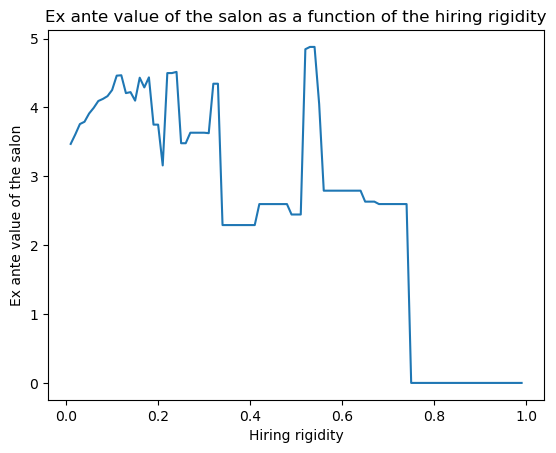

This will be plotted against earlier results to show the difference
As such we can see that the new optimized hiring and firing rigidity increases the ex ante value of the salon
In practice what this means is that the salon owner is best off choosing a hiring/firing rigidity of 0.53 which means that he/she should react to a change in demand by firing or hiring a worker if the change is larger than 0.53 and otherwise not
It essentially dampens the reaction of the salon owner to demand shocks, that are random, which is why the ex ante value of the salon increases


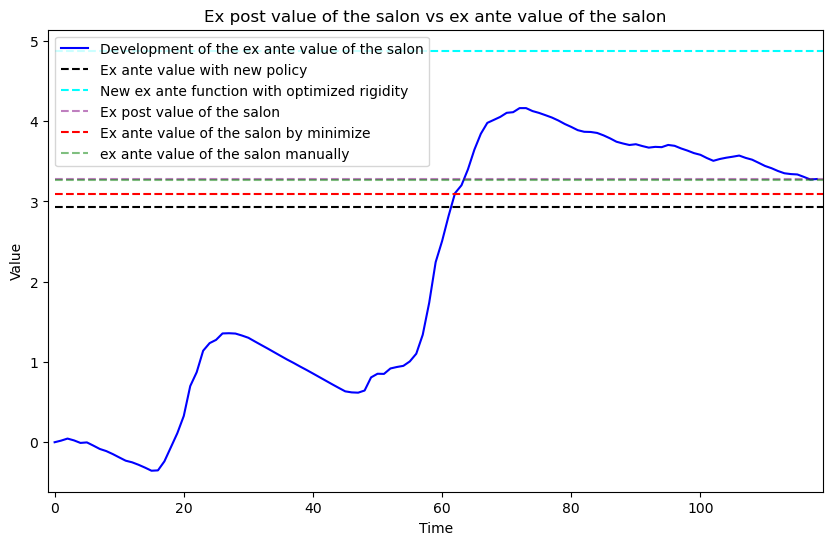

In [12]:

# a) We make a fucntion that calculates the ex ante value of the salon for a given hiring rigidity and plots it
# This is done to inspect how hiring rigidity affects the ex ante value of the salon
def PlotHfun2c():
    x = np.linspace(0.01,0.99,99) # We create a vector of x values
    y = np.zeros(99) # We create an empty vector to store the y values
    for i in range(0,99): # We iterate the loop 99 times
        y[i] = Hfun2c(x[i]) # We store the y values in the vector y

    print("The optimal hiring cost is", x[np.argmax(y)])
    plt.plot(x,y) # We plot the results
    plt.title("Ex ante value of the salon as a function of the hiring rigidity")
    plt.ylabel("Ex ante value of the salon")
    plt.xlabel("Hiring rigidity")
    plt.show()

# b) We call the function
PlotHfun2c()

# c) this will be compared to earlier results to see how the new policy changes the ex ante value of the salon
print("This will be plotted against earlier results to show the difference")
#Plot the results
fig, ax = plt.subplots( figsize=(10, 6))  
ax.plot(Graph, label = "Development of the ex ante value of the salon", color = "blue")
# ax.plot(Graph2, label = "Development of the ex ante value of the salon", color = "blue")
ax.hlines(Test2,0,t,label = "Ex ante value with new policy ", linestyles = "dashed", color = "black", alpha = 1)
ax.hlines(Hfun2c(0.53),0,t,label = "New ex ante function with optimized rigidity ", linestyles = "dashed", color = "cyan", alpha = 1)
ax.hlines(hresult, 0, t, linestyles='dashed', label = "Ex post value of the salon", color = "purple", alpha = 0.5)
ax.hlines(ExAnteH,0,t,label = "Ex ante value of the salon by minimize", linestyles = "dashed", color = "red")
ax.hlines(test,0,t,label = "ex ante value of the salon manually", linestyles = "dashed", color = "Green", alpha = 0.5)
ax.legend()
ax.set_title("Ex post value of the salon vs ex ante value of the salon")
ax.set_ylabel("Value")
ax.set_xlabel("Time")
ax.set_xlim(-1,119) 

print("As such we can see that the new optimized hiring and firing rigidity increases the ex ante value of the salon")
print("In practice what this means is that the salon owner is best off choosing a hiring/firing rigidity of 0.53 which means that he/she should react to a change in demand by firing or hiring a worker if the change is larger than 0.53 and otherwise not")
print("It essentially dampens the reaction of the salon owner to demand shocks, that are random, which is why the ex ante value of the salon increases")


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [13]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

<p style='color: lightblue;'> We have chosen to combine the code and output from Q3.1 and Q3.2 into one. This is done to make it easier to see the difference between the two warm-up iterrations.

In [14]:
# write your code here
import numpy as np
from scipy.optimize import minimize
np.random.seed(123)

# Define the Griewank function
def griewank(x):
    return griewank_(x[0], x[1])

# Define the Griewank_ function
def griewank_(x1, x2):
    A = x1**2 / 4000 + x2**2 / 4000
    B = np.cos(x1 / np.sqrt(1)) * np.cos(x2 / np.sqrt(2))
    return A - B + 1

# Define the refined global optimizer
def refined_global_optimizer(bounds, tolerance, K_warmup, K_max):
    # Initialize the best point and function value
    x_best = None # Best point
    f_best = np.inf # Best function value

    # Loop over the iterations
    for k in range(K_max):
        # Generate a random point
        x = np.random.uniform(bounds[0], bounds[1], size=(2))
        

        if k >= K_warmup:
            chi = 0.5 * (2 / (1 + np.exp((k - K_warmup) / 100)))
            x_k0 = chi * x + (1 - chi) * x_best
            x0 = x_k0
        else:
            x0 = x
        
        # Run the optimizer 
        res = minimize(griewank, x0, method='BFGS', tol=tolerance)

        # Print the first 10 results and if we reach a better point
        if k < 10 or res.fun < f_best:   
            if res.success and res.fun < f_best:
                x_best = res.x # Update the best point
                f_best = res.fun # Update the best function value

            print(f"{k:4d}: x0 = ({x0[0]:7.2f}, {x0[1]:7.2f})", end='')
            print(f" -> converged at ({res.x[0]:7.2f}, {res.x[1]:7.2f}) with f = {res.fun:12.8f}")
        
        # Break when the tolerance is hit
        if f_best < tolerance:
            break


    return x_best, k + 1 # Return the best point and the number of iterations

# a. Define parameters
bounds = [-600, 600] # Bounds for the optimizer
tolerance = 1e-8 # Tolerance for the optimizer
K_warmup = 10 # Number of warm-up iterations
K_max = 1000 # Maximum number of iterations

warmup_iterations = [10, 100]  # Different warm-up iterations to compare


# b. Run the optimizer for different warm-up iterations
for K_warmup in warmup_iterations:
    x_opt, iterations = refined_global_optimizer(bounds, tolerance, K_warmup, K_max)

    # Print the optimized solution
    print() # Print empty line
    print("Warm up iterrations:", K_warmup) # Print the number of warm-up iterations
    print("Optimized solution:") # Print the optimized solution
    print("x1 =", x_opt[0]) # Print the optimized x1
    print("x2 =", x_opt[1]) # Print the optimized x2
    print("f(x_opt) =", griewank(x_opt)) # Print the optimized function value
    print("Number of iterations:", iterations) # Print the number of iterations
    print() # Print empty line


   0: x0 = ( 235.76, -256.63) -> converged at ( 235.50, -252.99) with f =  29.88918424
   1: x0 = (-327.78,   61.58) -> converged at (-326.56,   62.14) with f =  27.64028508
   2: x0 = ( 263.36,  -92.27) -> converged at ( 260.62,  -93.21) with f =  19.16347356
   3: x0 = ( 576.92,  221.80) -> converged at ( 577.76,  221.91) with f =  95.81838204
   4: x0 = ( -22.88, -129.46) -> converged at ( -21.98, -128.71) with f =   4.26686174
   5: x0 = (-188.19,  274.86) -> converged at (-188.40,  275.18) with f =  27.82848331
   6: x0 = ( -73.71, -528.39) -> converged at ( -72.22, -528.16) with f =  71.11562711
   7: x0 = (-122.35,  285.59) -> converged at (-122.46,  288.50) with f =  24.57963809
   8: x0 = (-381.01, -389.46) -> converged at (-379.93, -386.13) with f =  73.42034286
   9: x0 = (  37.86,   38.19) -> converged at (  37.68,   35.51) with f =   0.67063995
  16: x0 = ( -20.83,   14.61) -> converged at ( -21.98,   13.32) with f =   0.16521108
 159: x0 = (  -5.57,   10.99) -> converged 

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In general more warm-up iterrations can improve convergence in optimizing algorithims. Warm-up iterrations can also improve the chances of finding the global minimum due to better oppritunities of escaping local minima.

We can observe the results from question 1 since the code varies the warmup iterrations to runs the code with respect to 10 warmup iterrations and 100. We see that the increased number of of warm-up iterrations result in the total number of interations decreasing from 356 to 256. This therefore means that it convergenes faster with 100 warmup iterrations.

It should be noted that warm-up iterrations may consume computational resources without providing substantial benefits meaning that the amount of warm-up iterrations should be choosen with a balance of rifinement and explorration.